
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
STARTING VENDOR SEGMENTATION ANALYSIS
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
VENDOR FEATURE ENGINEERING

✅ Created 18 features for 27 vendors

Feature summary:
        total_spend  avg_invoice  spend_volatility  transaction_count  \
count  2.700000e+01        27.00             27.00              27.00   
mean   2.151435e+07    161404.82          84947.46              55.56   
std    4.393401e+07    218714.02         116282.22              63.56   
min    2.809495e+04      6965.11           2907.20               2.00   
25%    3.513306e+05     25445.02          14054.62              12.00   
50%    1.238011e+06     65158.46          39812.58              20.00   
75%    1.098477e+07    153178.08          71069.83              74.50   
max    1.769055e+08    867183.75         471150.24             208.00   

       min_invoice  max_invoice  months_active  avg_gst_rate  credit_ratio  \
count        27.00        27.00          27.00         27.00

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/vendor_clusters_visualization.png'

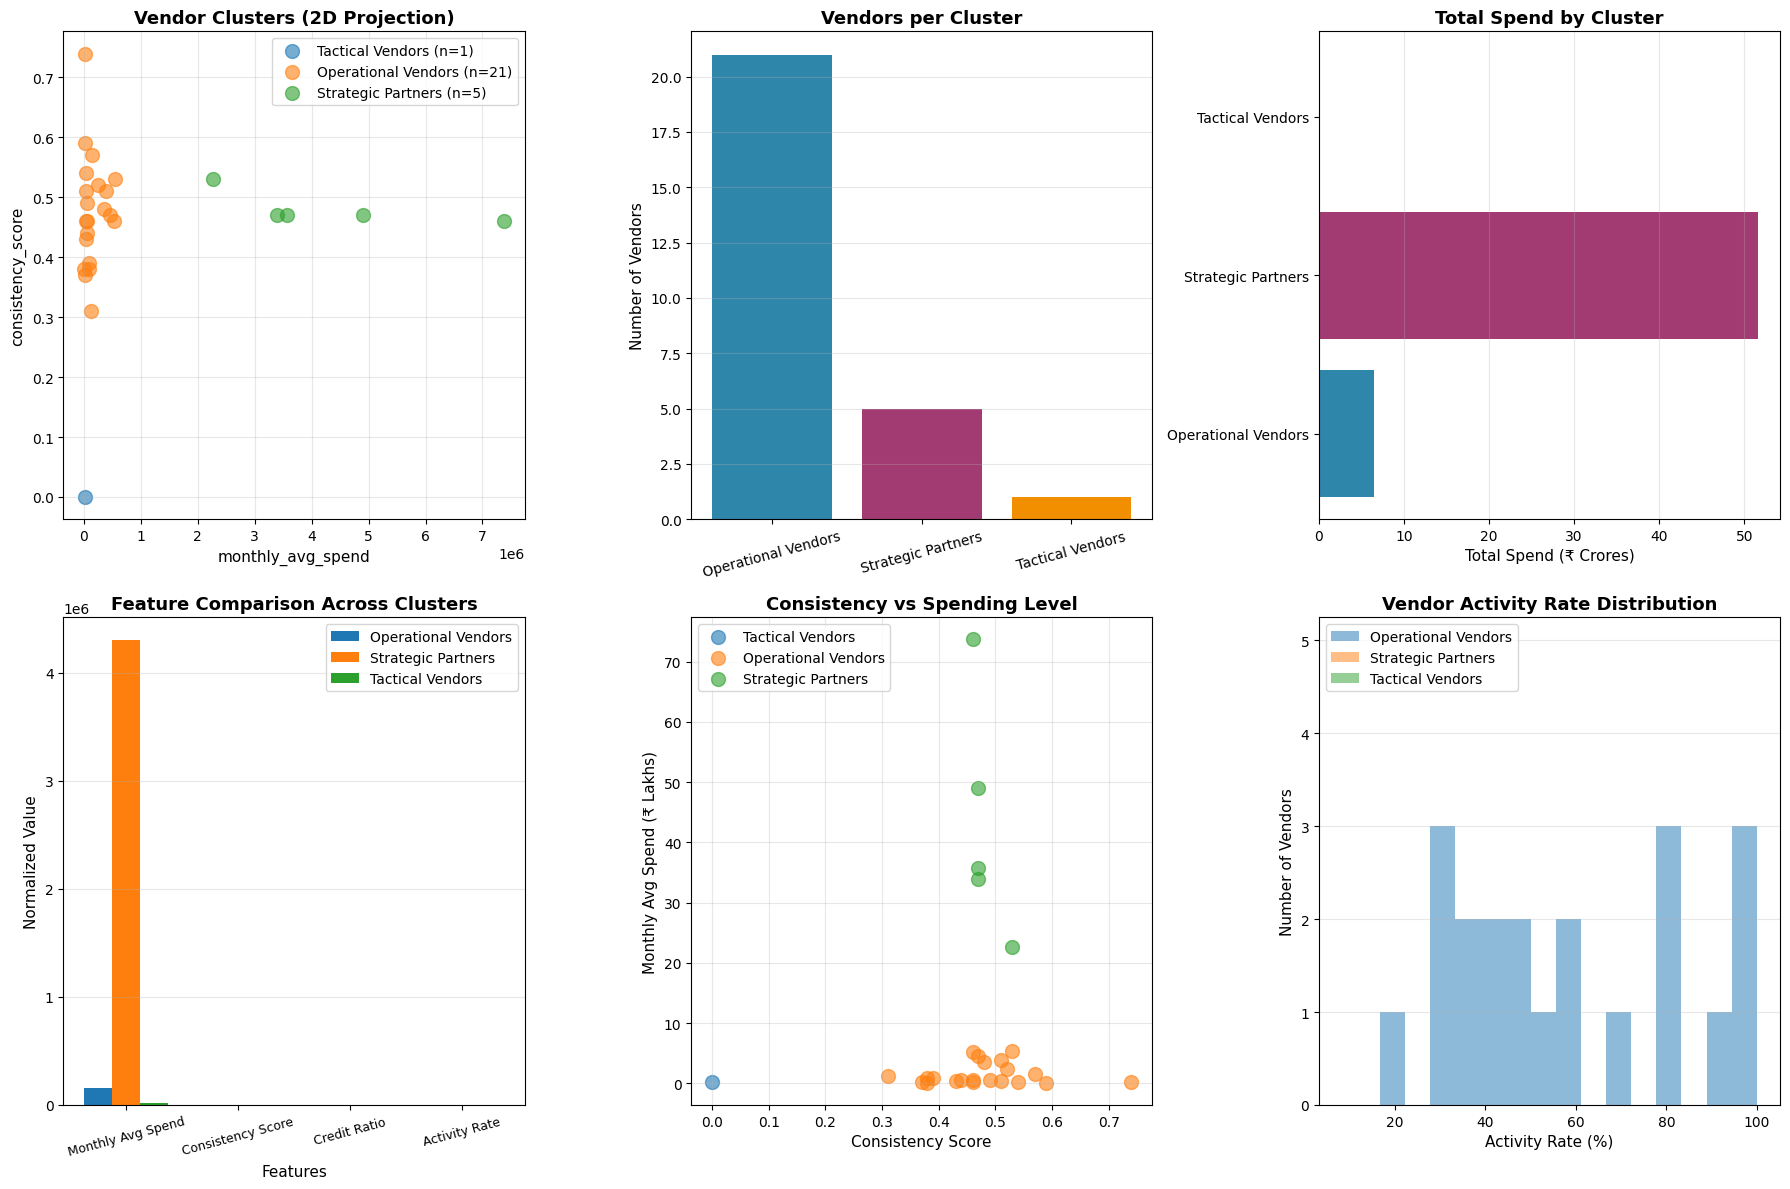

In [2]:
"""
VENDOR SEGMENTATION MODULE
AINextBill Technology - Purchase Invoice Analysis

This module performs K-Means clustering on vendors to enable:
- Strategic vendor classification
- Payment prioritization
- Cash flow optimization
- Vendor relationship management

Author: Data Science Intern
Date: February 2026
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')


class VendorSegmentation:
    """
    Segment vendors into strategic groups using K-Means clustering
    for better cash flow management and vendor relationship optimization.
    """
    
    def __init__(self, df):
        """
        Initialize the vendor segmentation analyzer.
        
        Args:
            df (pd.DataFrame): Cleaned invoice dataframe
        """
        self.df = df.copy()
        self.vendor_features = None
        self.scaler = StandardScaler()
        self.kmeans_model = None
        self.optimal_k = None
        
    
    def engineer_vendor_features(self):
        """
        Create vendor-level features for clustering.
        
        FEATURES CREATED:
        1. total_spend: Total amount spent with vendor
        2. avg_invoice: Average invoice value
        3. spend_volatility: Standard deviation of invoice amounts
        4. transaction_count: Number of transactions
        5. months_active: Number of unique months with transactions
        6. monthly_avg_spend: Average spend per active month
        7. consistency_score: 1 - (volatility / avg_invoice)
        8. credit_ratio: Percentage of invoices paid via credit
        9. avg_gst_rate: Average GST rate (indicates service type)
        10. high_value_ratio: Percentage of high-value invoices
        
        Returns:
            pd.DataFrame: Vendor-level feature matrix
        """
        print("=" * 80)
        print("VENDOR FEATURE ENGINEERING")
        print("=" * 80)
        
        # Calculate total months in dataset
        total_months = self.df['invoice_month'].nunique()
        
        # Define high-value threshold (90th percentile)
        high_value_threshold = self.df['invoice_amount'].quantile(0.90)
        
        # Aggregate features by vendor
        self.vendor_features = self.df.groupby('vendor_name').agg({
            'invoice_amount': ['sum', 'mean', 'std', 'count', 'min', 'max'],
            'invoice_month': 'nunique',
            'gst_rate': 'mean',
            'payment_mode': lambda x: (x == 'Credit').sum() / len(x) * 100,
            'total_amount': 'sum',
            'gst_amount': 'sum'
        }).round(2)
        
        # Flatten column names
        self.vendor_features.columns = [
            'total_spend', 'avg_invoice', 'spend_volatility', 
            'transaction_count', 'min_invoice', 'max_invoice',
            'months_active', 'avg_gst_rate', 'credit_ratio',
            'total_payable', 'total_gst'
        ]
        
        # Derived features
        
        # 1. Monthly average spend
        self.vendor_features['monthly_avg_spend'] = (
            self.vendor_features['total_spend'] / 
            self.vendor_features['months_active']
        ).round(2)
        
        # 2. Consistency score (inverse of coefficient of variation)
        # Higher score = more consistent/predictable
        cv = self.vendor_features['spend_volatility'] / self.vendor_features['avg_invoice']
        self.vendor_features['consistency_score'] = (1 - cv.clip(upper=1)).round(2)
        
        # 3. Activity rate (% of months active)
        self.vendor_features['activity_rate'] = (
            self.vendor_features['months_active'] / total_months * 100
        ).round(2)
        
        # 4. Average invoice frequency (invoices per active month)
        self.vendor_features['invoice_frequency'] = (
            self.vendor_features['transaction_count'] / 
            self.vendor_features['months_active']
        ).round(2)
        
        # 5. Invoice value range (max - min)
        self.vendor_features['invoice_range'] = (
            self.vendor_features['max_invoice'] - 
            self.vendor_features['min_invoice']
        ).round(2)
        
        # 6. High-value transaction ratio
        high_value_counts = self.df[
            self.df['invoice_amount'] > high_value_threshold
        ].groupby('vendor_name').size()
        
        self.vendor_features['high_value_ratio'] = (
            high_value_counts / self.vendor_features['transaction_count'] * 100
        ).fillna(0).round(2)
        
        # 7. GST burden (average GST per transaction)
        self.vendor_features['avg_gst_per_invoice'] = (
            self.vendor_features['total_gst'] / 
            self.vendor_features['transaction_count']
        ).round(2)
        
        print(f"\n✅ Created {len(self.vendor_features.columns)} features for {len(self.vendor_features)} vendors")
        print(f"\nFeature summary:")
        print(self.vendor_features.describe().round(2))
        
        return self.vendor_features
    
    
    def select_clustering_features(self):
        """
        Select the most relevant features for clustering.
        
        SELECTED FEATURES:
        1. monthly_avg_spend: Financial importance
        2. consistency_score: Spending predictability
        3. credit_ratio: Payment terms indicator
        4. activity_rate: Vendor engagement level
        
        Returns:
            np.array: Scaled feature matrix for clustering
        """
        print("\n" + "=" * 80)
        print("FEATURE SELECTION FOR CLUSTERING")
        print("=" * 80)
        
        # Select features based on business importance
        clustering_features = [
            'monthly_avg_spend',    # Strategic importance (spend level)
            'consistency_score',    # Predictability (stable vs volatile)
            'credit_ratio',         # Payment terms (cash flow impact)
            'activity_rate'         # Engagement level (recurring vs occasional)
        ]
        
        print(f"\n✅ Selected {len(clustering_features)} features:")
        for i, feature in enumerate(clustering_features, 1):
            print(f"   {i}. {feature}")
        
        # Extract feature matrix
        X = self.vendor_features[clustering_features].values
        
        # Handle any NaN or infinite values
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Standardize features (critical for K-Means)
        X_scaled = self.scaler.fit_transform(X)
        
        print(f"\n✅ Feature matrix shape: {X_scaled.shape}")
        print(f"✅ Features scaled using StandardScaler")
        
        return X_scaled, clustering_features
    
    
    def find_optimal_clusters(self, X_scaled, max_k=6):
        """
        Find optimal number of clusters using elbow method and silhouette score.
        
        Args:
            X_scaled (np.array): Scaled feature matrix
            max_k (int): Maximum number of clusters to test
            
        Returns:
            int: Optimal number of clusters
        """
        print("\n" + "=" * 80)
        print("FINDING OPTIMAL NUMBER OF CLUSTERS")
        print("=" * 80)
        
        # Calculate metrics for different k values
        inertias = []
        silhouette_scores = []
        k_values = range(2, max_k + 1)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
        
        # Print results
        print("\n📊 Clustering Metrics:")
        print(f"{'K':<5} {'Inertia':<15} {'Silhouette Score':<20}")
        print("-" * 40)
        for k, inertia, sil_score in zip(k_values, inertias, silhouette_scores):
            print(f"{k:<5} {inertia:<15.2f} {sil_score:<20.4f}")
        
        # Select k with highest silhouette score
        best_k_idx = np.argmax(silhouette_scores)
        self.optimal_k = list(k_values)[best_k_idx]
        
        print(f"\n✅ Optimal K (highest silhouette score): {self.optimal_k}")
        print(f"   Silhouette Score: {silhouette_scores[best_k_idx]:.4f}")
        
        # Visualize elbow curve
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Elbow curve
        ax1.plot(k_values, inertias, marker='o', linewidth=2, markersize=8)
        ax1.set_xlabel('Number of Clusters (K)', fontsize=11)
        ax1.set_ylabel('Inertia', fontsize=11)
        ax1.set_title('Elbow Method for Optimal K', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette scores
        ax2.plot(k_values, silhouette_scores, marker='s', linewidth=2, 
                 markersize=8, color='green')
        ax2.axvline(x=self.optimal_k, color='red', linestyle='--', 
                    label=f'Optimal K={self.optimal_k}')
        ax2.set_xlabel('Number of Clusters (K)', fontsize=11)
        ax2.set_ylabel('Silhouette Score', fontsize=11)
        ax2.set_title('Silhouette Score by K', fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('/mnt/user-data/outputs/optimal_k_selection.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"✅ Saved optimal K visualization")
        
        return self.optimal_k
    
    
    def perform_clustering(self, X_scaled, n_clusters=None):
        """
        Perform K-Means clustering on vendor features.
        
        Args:
            X_scaled (np.array): Scaled feature matrix
            n_clusters (int, optional): Number of clusters (uses optimal_k if None)
            
        Returns:
            np.array: Cluster assignments
        """
        print("\n" + "=" * 80)
        print("PERFORMING K-MEANS CLUSTERING")
        print("=" * 80)
        
        # Use optimal k if not specified
        if n_clusters is None:
            n_clusters = self.optimal_k if self.optimal_k else 3
        
        # Fit K-Means model
        self.kmeans_model = KMeans(
            n_clusters=n_clusters, 
            random_state=42, 
            n_init=10,
            max_iter=300
        )
        
        cluster_labels = self.kmeans_model.fit_predict(X_scaled)
        
        # Add cluster assignments to vendor features
        self.vendor_features['cluster'] = cluster_labels
        
        # Calculate silhouette score
        sil_score = silhouette_score(X_scaled, cluster_labels)
        
        print(f"\n✅ K-Means clustering completed")
        print(f"   Number of clusters: {n_clusters}")
        print(f"   Silhouette Score: {sil_score:.4f}")
        print(f"   Inertia: {self.kmeans_model.inertia_:.2f}")
        
        # Cluster size distribution
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        print(f"\n📊 Cluster Distribution:")
        for cluster_id, count in cluster_counts.items():
            print(f"   Cluster {cluster_id}: {count} vendors ({count/len(cluster_labels)*100:.1f}%)")
        
        return cluster_labels
    
    
    def interpret_clusters(self):
        """
        Analyze and interpret the meaning of each cluster.
        
        CLUSTER LABELING STRATEGY:
        - Cluster 0: Strategic Partners (high spend, consistent)
        - Cluster 1: Operational Vendors (moderate spend, regular)
        - Cluster 2: Tactical Vendors (low spend, irregular)
        
        Returns:
            dict: Cluster profiles and business interpretation
        """
        print("\n" + "=" * 80)
        print("CLUSTER INTERPRETATION")
        print("=" * 80)
        
        cluster_profiles = {}
        
        for cluster_id in sorted(self.vendor_features['cluster'].unique()):
            cluster_vendors = self.vendor_features[
                self.vendor_features['cluster'] == cluster_id
            ]
            
            print(f"\n{'='*80}")
            print(f"CLUSTER {cluster_id} ({len(cluster_vendors)} vendors)")
            print("=" * 80)
            
            # Calculate cluster statistics
            profile = {
                'size': len(cluster_vendors),
                'avg_monthly_spend': cluster_vendors['monthly_avg_spend'].mean(),
                'avg_consistency': cluster_vendors['consistency_score'].mean(),
                'avg_credit_ratio': cluster_vendors['credit_ratio'].mean(),
                'avg_activity_rate': cluster_vendors['activity_rate'].mean(),
                'total_spend': cluster_vendors['total_spend'].sum(),
                'vendors': cluster_vendors.index.tolist()
            }
            
            print(f"\n📊 Cluster Characteristics:")
            print(f"   Average monthly spend: ₹{profile['avg_monthly_spend']:,.2f}")
            print(f"   Consistency score: {profile['avg_consistency']:.2f}")
            print(f"   Credit payment ratio: {profile['avg_credit_ratio']:.1f}%")
            print(f"   Activity rate: {profile['avg_activity_rate']:.1f}%")
            print(f"   Total cluster spend: ₹{profile['total_spend']:,.2f}")
            
            print(f"\n🏢 Top 5 Vendors in this cluster:")
            top_vendors = cluster_vendors.nlargest(5, 'total_spend')
            for vendor, row in top_vendors.iterrows():
                print(f"   • {vendor}: ₹{row['total_spend']:,.2f} "
                      f"({row['transaction_count']:.0f} invoices)")
            
            cluster_profiles[cluster_id] = profile
        
        # Assign business labels based on characteristics
        cluster_labels = self._assign_cluster_labels(cluster_profiles)
        self.vendor_features['cluster_label'] = \
            self.vendor_features['cluster'].map(cluster_labels)
        
        print(f"\n{'='*80}")
        print("CLUSTER BUSINESS LABELS")
        print("=" * 80)
        for cluster_id, label in cluster_labels.items():
            vendor_count = (self.vendor_features['cluster'] == cluster_id).sum()
            total_spend = cluster_profiles[cluster_id]['total_spend']
            print(f"   Cluster {cluster_id}: {label} ({vendor_count} vendors, ₹{total_spend:,.2f})")
        
        return cluster_profiles, cluster_labels
    
    
    def _assign_cluster_labels(self, cluster_profiles):
        """
        Assign business-friendly labels to clusters based on their characteristics.
        
        Args:
            cluster_profiles (dict): Cluster characteristic profiles
            
        Returns:
            dict: Cluster ID to label mapping
        """
        # Sort clusters by average monthly spend
        sorted_clusters = sorted(
            cluster_profiles.items(),
            key=lambda x: x[1]['avg_monthly_spend'],
            reverse=True
        )
        
        labels = {}
        
        # Highest spend = Strategic Partners
        labels[sorted_clusters[0][0]] = "Strategic Partners"
        
        # Middle spend = Operational Vendors
        if len(sorted_clusters) > 2:
            labels[sorted_clusters[1][0]] = "Operational Vendors"
            labels[sorted_clusters[2][0]] = "Tactical Vendors"
        else:
            labels[sorted_clusters[1][0]] = "Tactical Vendors"
        
        return labels
    
    
    def visualize_clusters(self, features_to_plot, save_path=None):
        """
        Create visualizations of vendor clusters.
        
        Args:
            features_to_plot (list): Features used in clustering
            save_path (str, optional): Path to save visualizations
        """
        print("\n" + "=" * 80)
        print("GENERATING CLUSTER VISUALIZATIONS")
        print("=" * 80)
        
        # Create figure with multiple subplots
        fig = plt.figure(figsize=(18, 12))
        
        # 1. 2D Scatter Plot (first two features)
        ax1 = plt.subplot(2, 3, 1)
        
        for cluster_id in sorted(self.vendor_features['cluster'].unique()):
            cluster_data = self.vendor_features[
                self.vendor_features['cluster'] == cluster_id
            ]
            label = self.vendor_features.loc[
                cluster_data.index[0], 'cluster_label'
            ]
            
            ax1.scatter(
                cluster_data[features_to_plot[0]],
                cluster_data[features_to_plot[1]],
                label=f'{label} (n={len(cluster_data)})',
                s=100,
                alpha=0.6
            )
        
        ax1.set_xlabel(features_to_plot[0], fontsize=11)
        ax1.set_ylabel(features_to_plot[1], fontsize=11)
        ax1.set_title('Vendor Clusters (2D Projection)', fontsize=13, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Cluster Size Distribution
        ax2 = plt.subplot(2, 3, 2)
        cluster_counts = self.vendor_features['cluster_label'].value_counts()
        
        ax2.bar(range(len(cluster_counts)), cluster_counts.values, 
                color=['#2E86AB', '#A23B72', '#F18F01'])
        ax2.set_xticks(range(len(cluster_counts)))
        ax2.set_xticklabels(cluster_counts.index, rotation=15)
        ax2.set_ylabel('Number of Vendors', fontsize=11)
        ax2.set_title('Vendors per Cluster', fontsize=13, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Spending Distribution by Cluster
        ax3 = plt.subplot(2, 3, 3)
        cluster_spend = self.vendor_features.groupby('cluster_label')['total_spend'].sum() / 10000000
        
        ax3.barh(range(len(cluster_spend)), cluster_spend.values, 
                 color=['#2E86AB', '#A23B72', '#F18F01'])
        ax3.set_yticks(range(len(cluster_spend)))
        ax3.set_yticklabels(cluster_spend.index)
        ax3.set_xlabel('Total Spend (₹ Crores)', fontsize=11)
        ax3.set_title('Total Spend by Cluster', fontsize=13, fontweight='bold')
        ax3.grid(axis='x', alpha=0.3)
        
        # 4. Feature Comparison Across Clusters
        ax4 = plt.subplot(2, 3, 4)
        
        cluster_means = self.vendor_features.groupby('cluster_label')[
            features_to_plot
        ].mean()
        
        x = np.arange(len(features_to_plot))
        width = 0.25
        
        for i, (label, row) in enumerate(cluster_means.iterrows()):
            ax4.bar(x + i*width, row.values, width, label=label)
        
        ax4.set_xlabel('Features', fontsize=11)
        ax4.set_ylabel('Normalized Value', fontsize=11)
        ax4.set_title('Feature Comparison Across Clusters', fontsize=13, fontweight='bold')
        ax4.set_xticks(x + width)
        ax4.set_xticklabels([f.replace('_', ' ').title() for f in features_to_plot], 
                            rotation=15, fontsize=9)
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        # 5. Consistency vs Spend
        ax5 = plt.subplot(2, 3, 5)
        
        for cluster_id in sorted(self.vendor_features['cluster'].unique()):
            cluster_data = self.vendor_features[
                self.vendor_features['cluster'] == cluster_id
            ]
            label = cluster_data.iloc[0]['cluster_label']
            
            ax5.scatter(
                cluster_data['consistency_score'],
                cluster_data['monthly_avg_spend'] / 100000,  # In lakhs
                label=label,
                s=100,
                alpha=0.6
            )
        
        ax5.set_xlabel('Consistency Score', fontsize=11)
        ax5.set_ylabel('Monthly Avg Spend (₹ Lakhs)', fontsize=11)
        ax5.set_title('Consistency vs Spending Level', fontsize=13, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Activity Rate Distribution
        ax6 = plt.subplot(2, 3, 6)
        
        for label in self.vendor_features['cluster_label'].unique():
            cluster_data = self.vendor_features[
                self.vendor_features['cluster_label'] == label
            ]
            ax6.hist(cluster_data['activity_rate'], bins=15, alpha=0.5, label=label)
        
        ax6.set_xlabel('Activity Rate (%)', fontsize=11)
        ax6.set_ylabel('Number of Vendors', fontsize=11)
        ax6.set_title('Vendor Activity Rate Distribution', fontsize=13, fontweight='bold')
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/vendor_clusters_visualization.png", 
                       dpi=300, bbox_inches='tight')
            print(f"✅ Saved visualization to: {save_path}/vendor_clusters_visualization.png")
        
        plt.show()
        
        print("✅ Cluster visualizations generated successfully")
    
    
    def generate_business_recommendations(self):
        """
        Generate actionable business recommendations based on clusters.
        
        Returns:
            dict: Cluster-specific recommendations
        """
        print("\n" + "=" * 80)
        print("BUSINESS RECOMMENDATIONS BY CLUSTER")
        print("=" * 80)
        
        recommendations = {}
        
        for label in sorted(self.vendor_features['cluster_label'].unique()):
            cluster_vendors = self.vendor_features[
                self.vendor_features['cluster_label'] == label
            ]
            
            print(f"\n📌 {label.upper()} ({len(cluster_vendors)} vendors):")
            print("-" * 80)
            
            avg_spend = cluster_vendors['monthly_avg_spend'].mean()
            avg_credit = cluster_vendors['credit_ratio'].mean()
            
            if "Strategic" in label:
                recs = [
                    f"💰 Negotiate volume discounts (avg monthly spend: ₹{avg_spend:,.2f})",
                    f"📅 Set up automated monthly payment cycles",
                    f"🤝 Quarterly business reviews with key vendors",
                    f"💳 Leverage {avg_credit:.1f}% credit usage for better terms"
                ]
            elif "Operational" in label:
                recs = [
                    f"⚙️ Automate invoice approval for routine purchases",
                    f"📊 Monitor for cost optimization opportunities",
                    f"🔄 Standard NET-30 payment terms",
                    f"📈 Track spend trends monthly"
                ]
            else:  # Tactical
                recs = [
                    f"⚡ Enable quick approval for small invoices (<₹50,000)",
                    f"🔍 Review need for these vendors (consolidation opportunity)",
                    f"💸 Instant payment for invoices <₹25,000",
                    f"📝 Minimal documentation requirements"
                ]
            
            recommendations[label] = recs
            
            for rec in recs:
                print(f"   {rec}")
        
        return recommendations
    
    
    def run_full_segmentation(self, n_clusters=None, save_outputs=True, output_path=None):
        """
        Execute complete vendor segmentation pipeline.
        
        Args:
            n_clusters (int, optional): Number of clusters (auto-detected if None)
            save_outputs (bool): Whether to save results
            output_path (str): Directory for outputs
            
        Returns:
            dict: Complete segmentation results
        """
        print("\n" + "🚀" * 40)
        print("STARTING VENDOR SEGMENTATION ANALYSIS")
        print("🚀" * 40)
        
        # Step 1: Engineer features
        self.engineer_vendor_features()
        
        # Step 2: Select clustering features
        X_scaled, feature_names = self.select_clustering_features()
        
        # Step 3: Find optimal k (if not specified)
        if n_clusters is None:
            self.find_optimal_clusters(X_scaled, max_k=6)
            n_clusters = self.optimal_k
        
        # Step 4: Perform clustering
        self.perform_clustering(X_scaled, n_clusters)
        
        # Step 5: Interpret clusters
        profiles, labels = self.interpret_clusters()
        
        # Step 6: Visualize
        if save_outputs and output_path:
            self.visualize_clusters(feature_names, save_path=output_path)
        
        # Step 7: Generate recommendations
        recommendations = self.generate_business_recommendations()
        
        # Step 8: Save results
        if save_outputs and output_path:
            self.vendor_features.to_csv(
                f"{output_path}/vendor_clusters.csv"
            )
            print(f"\n✅ Saved vendor clusters to: {output_path}/vendor_clusters.csv")
        
        print("\n" + "✅" * 40)
        print("VENDOR SEGMENTATION COMPLETE!")
        print("✅" * 40)
        
        return {
            'vendor_features': self.vendor_features,
            'cluster_profiles': profiles,
            'cluster_labels': labels,
            'recommendations': recommendations,
            'model': self.kmeans_model
        }


# =============================================================================
# USAGE EXAMPLE
# =============================================================================

if __name__ == "__main__":
    """
    Example usage of the VendorSegmentation class.
    """
    
    # Load cleaned data
    df = pd.read_csv('cleaned_invoices.csv')
    
    # Convert invoice_month to Period
    df['invoice_month'] = pd.PeriodIndex(df['invoice_month'], freq='M')
    
    # Initialize segmentation
    segmenter = VendorSegmentation(df)
    
    # Run full analysis
    results = segmenter.run_full_segmentation(
        n_clusters=3,  # Or None for auto-detection
        save_outputs=True,
        output_path='outputs'
    )
    
    print("\n✅ Vendor segmentation analysis complete!")
    print(f"✅ Results saved to /mnt/user-data/outputs/")